# ML Pipeline Demonstration

This notebook demonstrates how to use the ML Pipeline for LGBM classification. It covers the basic functionality of each component and shows how they work together.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the ML pipeline
from ml_pipeline import DataLoader, DataProcessor, ML_Pipeline

# Set up paths
TRAIN_CONFIG_PATH = "data_config_train.json"
TEST_CONFIG_PATH = "data_config_test.json"
MODEL_CONFIG_PATH = "model_config.json"

# Create output directory if it doesn't exist
os.makedirs("trained_model_outputs_path", exist_ok=True)

## 1. Data Loader Demonstration

First, let's demonstrate the DataLoader class which handles loading and validating the data.

In [2]:
# Initialize the data loader with training configuration
data_loader = DataLoader(TRAIN_CONFIG_PATH, MODEL_CONFIG_PATH)

# Get configurations
data_config = data_loader.get_data_config()
model_config = data_loader.get_model_config()

print("Data config:")
for key, value in data_config.items():
    print(f"  {key}: {value}")

print("\nModel config:")
for key, value in model_config.items():
    if key != "hyperparameter_space":  # Skip printing hyperparameter space for brevity
        print(f"  {key}: {value}")

Data config:
  training: True
  metadata_file_path: feature_metadata.xlsx
  input_data_source: CSV
  file_path: example_inputs_v1.csv

Model config:
  target_variable: target
  id_variables: ['id_col', 'date_col']
  problem_type: classification
  evaluation_metric: rocauc
  better_performance: gt
  models: ['lgbm']
  k_folds: 5
  retrain_with_whole_dataset: True
  sample_for_contribution: 1.0
  importance_extraction_method: treeinterpreter
  num_hp_searches: 5


In [3]:
# Get feature metadata
feature_metadata = data_loader.get_feature_metadata()
print("Feature metadata summary:")
print(f"  Total features: {len(feature_metadata)}")
print("\nFeature metadata preview:")
display(feature_metadata.head())

Feature metadata summary:
  Total features: 17

Feature metadata preview:


,feature_name,type,use,imputation,transformation,super_category
0,id_col,category,0,unknown,None,1_id
1,date_col,category,0,unknown,None,1_id
2,target,bool,1,unknown,NaN,2_DEPENDENT
3,feature_0,float,1,mean,Standardize,3_features
4,feature_1,float,1,mean,Standardize,3_features


In [4]:
# Get the data with correct data types
data = data_loader.get_data()
print("Data summary:")
print(f"  Shape: {data.shape}")
print(f"  Columns: {list(data.columns)}")
print("\nData preview:")
display(data.head())

print("\nData types:")
display(data.dtypes)

Data summary:
  Shape: (1000, 17)
  Columns: ['id_col', 'date_col', 'target', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13']

Data preview:


,id_col,date_col,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
0,tMDgt,1/1/2025,True,0.049852,-0.089866,-1.737027,-0.563298,1.438655,0.423646,-0.571617,2.344470,0.329684,-1.687705,c,NaN,True,True
1,RgeWT,1/1/2025,True,0.600273,1.293923,-0.768878,-1.674227,0.656431,-0.030041,1.393623,-1.575807,1.485816,0.163634,b,NaN,True,False
2,BXjMC,1/1/2025,False,-2.998233,0.631200,1.180551,0.640171,-1.244864,-0.020427,0.127345,1.303097,-1.408630,-1.171414,b,e,False,False
3,hwtkX,1/1/2025,True,2.641943,0.117200,-1.211940,-0.171758,0.657611,-1.026694,0.446694,-1.116131,3.546071,0.043762,b,d,True,True
4,nJfRw,1/1/2025,False,-3.386397,1.547925,0.356687,0.930875,-0.673196,0.976374,0.154054,1.594067,-1.075212,-0.985810,c,e,False,True



Data types:


id_col        category
date_col      category
target            bool
feature_0      float64
feature_1      float64
feature_2      float64
feature_3      float64
feature_4      float64
feature_5      float64
feature_6      float64
feature_7      float64
feature_8      float64
feature_9      float64
feature_10    category
feature_11    category
feature_12        bool
feature_13        bool
dtype: object

## 2. Data Processor Demonstration

Next, let's demonstrate the DataProcessor class which handles preprocessing the data.

In [5]:
# Initialize the data processor
data_processor = DataProcessor(
    feature_metadata=feature_metadata,
    model_config=model_config,
    output_dir="trained_model_outputs_path"
)

processed_data = data_processor.process_data(data, is_training=True, create_folds=True)


/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/

In [6]:
processed_data['folds'][0]['X_val_transformed']

,num__feature_0,num__feature_1,num__feature_2,num__feature_3,num__feature_4,num__feature_5,num__feature_6,num__feature_7,num__feature_8,onehot__feature_10_a,onehot__feature_10_b,onehot__feature_10_c,bin__feature_12,remainder__feature_9,remainder__feature_11,remainder__feature_13
1,0.235277,0.558604,0.003431,-1.557734,0.048145,-0.052376,1.278130,-1.286467,0.896656,0.0,1.0,0.0,1.0,0.163634,NaN,0.0
3,1.041906,-0.202040,-0.282392,-0.094758,0.048881,-1.064592,0.664801,-0.987840,2.132201,0.0,1.0,0.0,1.0,0.043762,d,1.0
6,0.412722,0.205337,-0.856774,1.634838,0.416893,-0.593451,-0.224563,0.411194,1.357260,0.0,1.0,0.0,0.0,-0.669059,NaN,1.0
10,0.494154,-0.592156,1.238101,0.327336,-1.210436,-0.587942,-0.185199,-1.386797,0.609904,0.0,0.0,1.0,1.0,-0.129590,NaN,1.0
24,1.828032,-2.051071,-0.311096,0.079577,0.410846,-0.549317,-1.757349,-0.262370,0.305976,0.0,1.0,0.0,1.0,1.354990,e,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,1.012947,-1.434806,0.250431,-1.182998,-0.163018,-0.042064,-1.335355,-0.205463,-0.048882,0.0,0.0,1.0,1.0,-1.378188,e,1.0
988,0.334797,0.226076,-0.444506,-0.192457,0.462756,-0.150504,-0.267814,-0.562076,-0.100551,0.0,1.0,0.0,0.0,1.426836,NaN,1.0
994,-0.660330,0.737357,0.001020,0.483677,-0.523212,2.113004,-1.060972,0.778175,0.144104,1.0,0.0,0.0,1.0,-1.737922,f,1.0
995,-1.262277,0.624853,1.036626,0.653376,-1.228723,-0.489462,-0.180892,0.601269,-0.523990,0.0,0.0,1.0,0.0,2.486020,NaN,1.0


In [7]:
# Preprocess the training data
print("Preprocessed data:")
print(f"  Features shape: {processed_data['X'].shape}")
print(f"  Target shape: {processed_data['y'].shape}")
print(f"  Number of folds: {len(processed_data['folds'])}")

# Print info for the first fold
first_fold = processed_data['folds'][0]
print("\nFirst fold:")
print(f"  Fold index: {first_fold['fold_idx']}")
print(f"  Training indices shape: {first_fold['train_idx'].shape}")
print(f"  Validation indices shape: {first_fold['val_idx'].shape}")
print(f"  X_train shape: {first_fold['X_train'].shape}")
print(f"  X_train_transformed shape: {first_fold['X_train_transformed'].shape}")
print(f"  X_val shape: {first_fold['X_val'].shape}")
print(f"  X_val_transformed shape: {first_fold['X_val_transformed'].shape}")

Preprocessed data:
  Features shape: (1000, 14)
  Target shape: (1000,)
  Number of folds: 5

First fold:
  Fold index: 0
  Training indices shape: (800,)
  Validation indices shape: (200,)
  X_train shape: (800, 14)
  X_train_transformed shape: (800, 16)
  X_val shape: (200, 14)
  X_val_transformed shape: (200, 16)


# Manual testing that transformed data can be used to train LGBM

In [8]:
# import lightgbm as lgbm

# params = {
#      "boosting_type": "gbdt",
#      "learning_rate": 0.1,
#      "num_leaves": 31,
#      "feature_fraction": 0.8,
#      "n_estimators": 100
# }

# train_data = lgbm.Dataset(first_fold['X_train_transformed'], label=first_fold['y_train'])

# lgbm.train(
# train_set = train_data,
# params = params
# )

## 3. ML Pipeline Demonstration

Finally, let's demonstrate the full ML_Pipeline class which integrates data loading, preprocessing, and model training.

In [9]:
# Initialize the ML pipeline for training
pipeline = ML_Pipeline(MODEL_CONFIG_PATH, TRAIN_CONFIG_PATH)
print(f"ML Pipeline initialized for {'training' if pipeline.is_training else 'testing'}")

# Run the pipeline for training
pipeline.run()

/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/

ML Pipeline initialized for training
Starting training pipeline...
Training lgbm models for classification problem...
Training with cross-validation hyperparameter optimization...
Starting hyperparameter tuning with Optuna using cross-validation...


<string>:1: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
<string>:1: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
<string>:1: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2025-04-04 22:47:49,555] Trial 2 finished with value: 0.8403644038849709 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.026098405572527846, 'num_leaves': 132.0, 'feature_fraction': 0.10734413991520587, 'reg_lambda': 0.0445429878549739, 'n_estimators': 154.0, 'class_weight': 'balanced', 'min_data_in_leaf': 270.0}. Best is trial 2 with value: 0

Number of finished trials: 5
Best trial: 4
Best rocauc: 0.8758553812213042
Best hyperparameters:
  boosting_type: gbdt
  learning_rate: 0.054134876930277694
  num_leaves: 87.0
  feature_fraction: 0.6535922354928935
  reg_lambda: 0.037164354486907226
  n_estimators: 154.0
  class_weight: balanced
  min_data_in_leaf: 285.0
Hyperparameter study results saved to trained_model_outputs_path/target_classification_lgbm_hyperparameter_study.csv
Hyperparameter study results saved to trained_model_outputs_path/target_classification_lgbm_hyperparameter_study.csv
Cross-validation average performance: 0.8758553812213042
Best hyperparameters:
  boosting_type: gbdt
  learning_rate: 0.054134876930277694
  num_leaves: 87.0
  feature_fraction: 0.6535922354928935
  reg_lambda: 0.037164354486907226
  n_estimators: 154.0
  class_weight: balanced
  min_data_in_leaf: 285.0
Retraining on full dataset...
Training model with best hyperparameters...
[100]	training's auc: 1
Training rocauc: 1.0
Model saved to trai

/Users/jonathanbugg/Desktop/ml_pipeline_second_try/bnbj_ml_pipeline/.venv/lib/python3.10/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [11]:
# Now initialize the ML pipeline for testing
test_pipeline = ML_Pipeline(MODEL_CONFIG_PATH, TEST_CONFIG_PATH)
print(f"ML Pipeline initialized for {'training' if test_pipeline.is_training else 'testing'}")

# Run the pipeline for testing
test_pipeline.run()

ML Pipeline initialized for testing
Starting testing pipeline...
Model loaded from trained_model_outputs_path/target_classification_lgbm.pkl
Predictions saved to trained_model_outputs_path/classification_v1.csv
Testing pipeline completed.


Predictions:
  Shape: (500, 3)
  Columns: ['prediction', 'id_col', 'date_col']


,prediction,id_col,date_col
0,0.000266,ofsGS,1/1/2025
1,0.999920,qqIVy,1/1/2025
2,0.009521,qfBQR,1/1/2025
3,0.001839,nYXTV,1/1/2025
4,0.000124,QirOv,1/1/2025


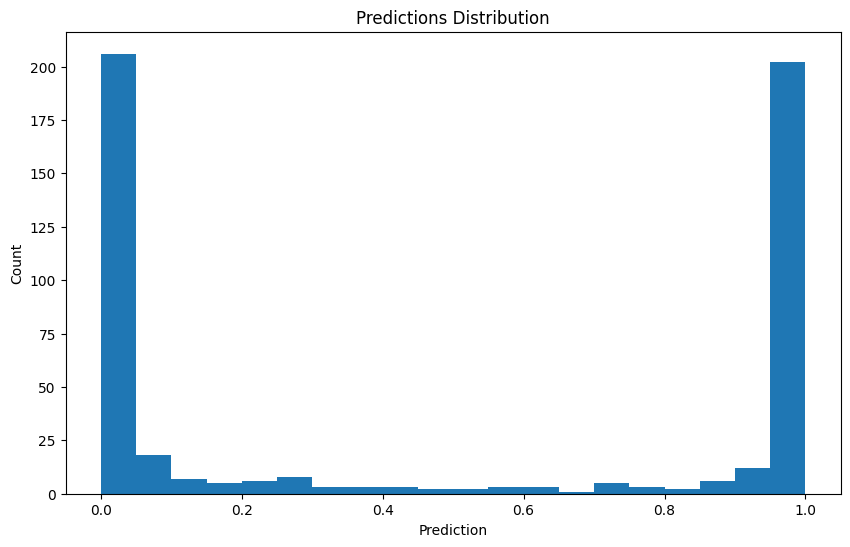

In [12]:
# Load and display the predictions
predictions_path = test_pipeline.data_config.get("predictions_output_path", "")
if os.path.exists(predictions_path):
    predictions_df = pd.read_csv(predictions_path)
    print("Predictions:")
    print(f"  Shape: {predictions_df.shape}")
    print(f"  Columns: {list(predictions_df.columns)}")
    display(predictions_df.head())
    
    # Visualize the predictions distribution
    plt.figure(figsize=(10, 6))
    plt.hist(predictions_df['prediction'], bins=20)
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Predictions Distribution')
    plt.show()
else:
    print(f"Predictions file not found at: {predictions_path}")

## 4. Optional: Feature Importance Analysis

If desired, we can analyze the feature importances from the trained LGBM model.

Feature importances:


,feature_idx,importance
1,1,146
6,6,96
4,4,86
8,8,79
7,7,61
2,2,41
0,0,40
3,3,0
5,5,0
9,9,0


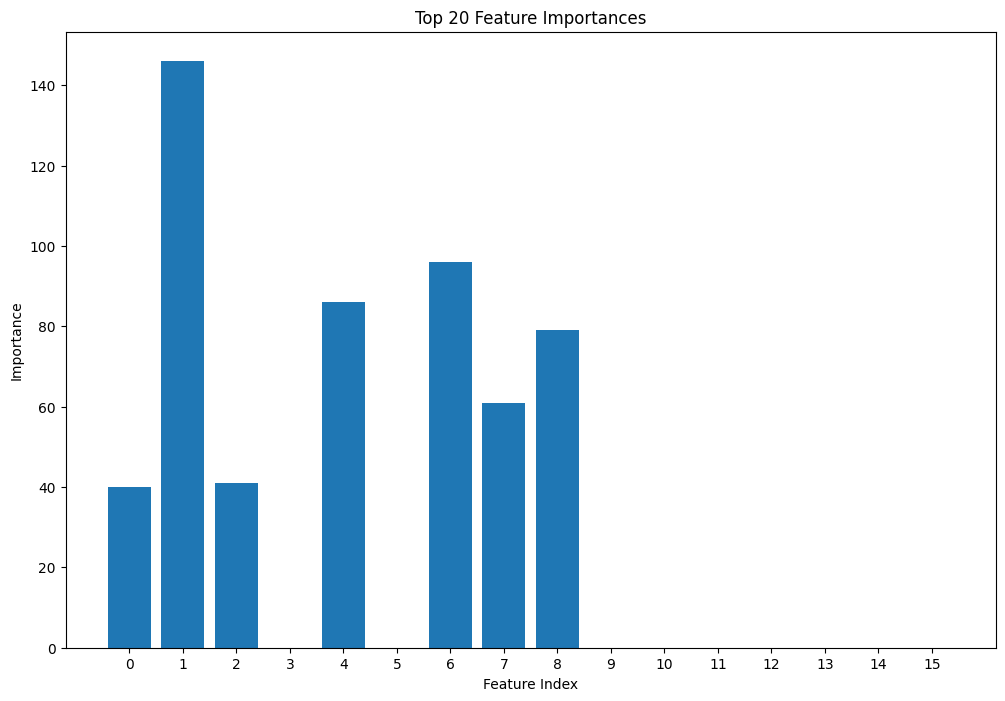

In [17]:
# Load the trained model
import pickle

model_path = os.path.join("trained_model_outputs_path", "target_classification_lgbm.pkl")
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    # Get feature importances
    feature_importance = model.feature_importance()
    
    # Map feature indices to feature names
    feature_indices = list(range(len(feature_importance)))
    
    # Create a dataframe of feature importances
    importance_df = pd.DataFrame({
        'feature_idx': feature_indices,
        'importance': feature_importance
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Display feature importances
    print("Feature importances:")
    display(importance_df.head(10))
    
    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    plt.bar(importance_df['feature_idx'].head(20), importance_df['importance'].head(20))
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.xticks(importance_df['feature_idx'].head(20))
    plt.show()
else:
    print(f"Model file not found at: {model_path}")